# Predicting Tanzania Water Pumps Functionality

**Author : Edwin Maina**



## Business Understanding

Access to clean  water is a fundamental human need and a key for public health, economic development, and social well-being. 

In Tanzania, communities heavily rely on water wells for their daily water supply. However, many of these water points become non-functional over time due to poor maintenance, environmental conditions, or inadequate infrastructure.

This project aims to build a predictive models to assess the functionality status of water wells in Tanzania. The models will help stakeholders prioritize maintenance efforts, allocate resources more effectively, and ensure that water wells remain operational for the communities that depend on them.


### Business Problem

Tanzania's water supply system is characterized by frequent water pump breakdowns resulting from lack of proper maintenance and inefficient management. This leads to disruptions in water supply, exacerbating the acute shortage of clean water and subsequent socio-economic losses.

The government of Tanzania, in collaboration with NGOs and partner organizations, aims to enhance access to clean water by improving the maintenance and functionality of water wells across the country. To achieve this, water point sustainability risk levels across the supply system need to be projected by learning from current point profiles to guide stakeholders' decisions through highlighting:

  - Most dilapidated wells that should be prioritized for maintenance, repairs, or rehabilitation.
  - Sites to be earmarked for future wells.
  - Data-driven recommendations that are responsive to stakeholders' needs and actionable guide improve management practices and water accessibility.


### Importing Required Libraries

In [52]:
# importing pandas for data wrangling and manipulation
import pandas as pd
import numpy as np

# importing matplotlib and seaborn for data visualization
import matplotlib.pyplot as plt
%matplotlib inline
%config inlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('notebook')

# Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import  accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
import random

### loading the Datasets

In [53]:
training_values = pd.read_csv('Trainig_set_values.csv')
training_values.head()


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [54]:
training_labels = pd.read_csv('Training_set_labels.csv')
training_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [55]:
test_values = pd.read_csv('Test_set_values.csv')
test_values.head()


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [56]:

# Merging the training values with the labels to create a complete training dataset
train_data = pd.merge(training_values, training_labels, on="id")

train_data.info()

train_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [57]:
train_data.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [58]:
# unique values in each column
{column: train_data[column].nunique() for column in train_data.columns}
    #Observations:

{'id': 59400,
 'amount_tsh': 98,
 'date_recorded': 356,
 'funder': 1897,
 'gps_height': 2428,
 'installer': 2145,
 'longitude': 57516,
 'latitude': 57517,
 'wpt_name': 37400,
 'num_private': 65,
 'basin': 9,
 'subvillage': 19287,
 'region': 21,
 'region_code': 27,
 'district_code': 20,
 'lga': 125,
 'ward': 2092,
 'population': 1049,
 'public_meeting': 2,
 'recorded_by': 1,
 'scheme_management': 12,
 'scheme_name': 2696,
 'permit': 2,
 'construction_year': 55,
 'extraction_type': 18,
 'extraction_type_group': 13,
 'extraction_type_class': 7,
 'management': 12,
 'management_group': 5,
 'payment': 7,
 'payment_type': 7,
 'water_quality': 8,
 'quality_group': 6,
 'quantity': 5,
 'quantity_group': 5,
 'source': 10,
 'source_type': 7,
 'source_class': 3,
 'waterpoint_type': 7,
 'waterpoint_type_group': 6,
 'status_group': 3}

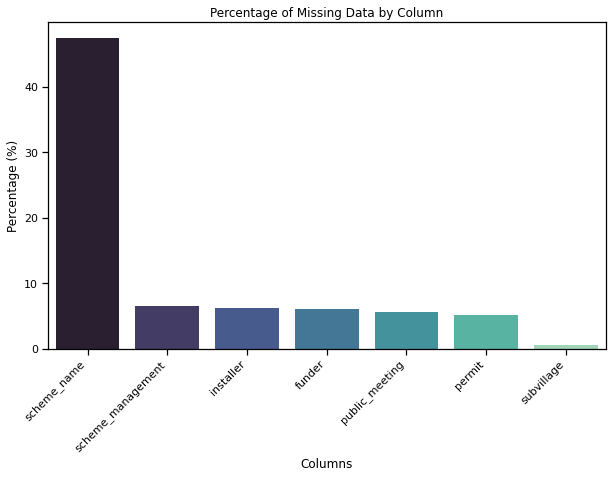

scheme_name          47.417508
scheme_management     6.526936
installer             6.153199
funder                6.119529
public_meeting        5.612795
permit                5.144781
subvillage            0.624579
dtype: float64

In [59]:
# Checking the percentage of missing values in each column
missing_data = train_data.isnull().mean() * 100

# Filtering columns with missing values only
missing_columns = missing_data[missing_data > 0].sort_values(ascending=False)

# Visualizing 
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_columns.index, y=missing_columns.values, palette='mako')
plt.title('Percentage of Missing Data by Column')
plt.ylabel('Percentage (%)')
plt.xlabel('Columns')
plt.xticks(rotation=45, ha='right')
plt.show()

missing_columns


## Data Cleaning

### Dropping Unnecessary Columns

I dropped the following columns as they were redundant as they represent the same thing or irrelevant  for the objective of our model:

- wpt_name: Name of the waterpoint (not relevant for our analysis).
- num_private: Number of private pumps.
- subvillage: Subvillage location.
- district_code: District code.
- lga: Local government authority .
- ward: Administrative ward .
- public_meeting: Whether there was a public meeting related to the waterpoint .
- recorded_by: Entity recording the data 
- scheme_name: Name of the waterpoint scheme .
extraction_type_group: Grouped extraction type (redundant with 'extraction_type').
management_group: Grouped management type (redundant with 'management').
payment: Payment method (redundant with 'payment_type').
quality_group: Grouped water quality (redundant with 'water_quality').
quantity_group: Grouped water quantity (redundant with 'quantity').
source_type: Source type (redundant with 'source').
waterpoint_type: Grouped waterpoint type (redundant with 'waterpoint_type').

In [60]:
def irrelevant_columns(data, columns):
    """
    Function for removing columns that either represent the same thing or are irrelevant to the model that will be built
    """                   
    cleaned_df = data.drop(columns, axis=1)
    return cleaned_df

In [61]:
irrelevant_columns1 = ['wpt_name', 'num_private', 'subvillage', 'region', 'lga',\
                       'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', \
                        'extraction_type_group', 'management_group','payment', 'quality_group', 'quantity_group', 'source', 'waterpoint_type_group'] 

train_data = irrelevant_columns(train_data, irrelevant_columns1)
train_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region_code,...,construction_year,extraction_type_class,management,payment_type,water_quality,quantity,source_type,source_class,waterpoint_type,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,11,...,1999,gravity,vwc,annually,soft,enough,spring,groundwater,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,20,...,2010,gravity,wug,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,21,...,2009,gravity,vwc,per bucket,soft,enough,dam,surface,communal standpipe multiple,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,90,...,1986,submersible,vwc,never pay,soft,dry,borehole,groundwater,communal standpipe multiple,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,18,...,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,functional


In [62]:
train_data.describe()


,id,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,99.000000,80.000000,30500.000000,2013.000000


In [63]:
{column: train_data[column].nunique() for column in train_data.columns}


{'id': 59400,
 'amount_tsh': 98,
 'date_recorded': 356,
 'funder': 1897,
 'gps_height': 2428,
 'installer': 2145,
 'longitude': 57516,
 'latitude': 57517,
 'basin': 9,
 'region_code': 27,
 'district_code': 20,
 'population': 1049,
 'permit': 2,
 'construction_year': 55,
 'extraction_type_class': 7,
 'management': 12,
 'payment_type': 7,
 'water_quality': 8,
 'quantity': 5,
 'source_type': 7,
 'source_class': 3,
 'waterpoint_type': 7,
 'status_group': 3}

In [64]:
train_data.duplicated().sum()

0

In [65]:
train_data.isnull().sum()


id                          0
amount_tsh                  0
date_recorded               0
funder                   3635
gps_height                  0
installer                3655
longitude                   0
latitude                    0
basin                       0
region_code                 0
district_code               0
population                  0
permit                   3056
construction_year           0
extraction_type_class       0
management                  0
payment_type                0
water_quality               0
quantity                    0
source_type                 0
source_class                0
waterpoint_type             0
status_group                0
dtype: int64

## EXPLORATORY DATA ANALYSIS

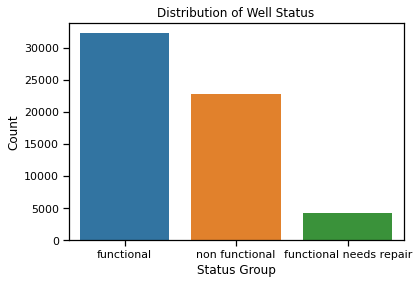

In [66]:
# Checking the distribution of the target variable 'status_group'
target_distribution = train_data['status_group'].value_counts(normalize=True) * 100

# Visualizing the distribution of the target variable
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=train_data, x='status_group', order=train_data['status_group'].value_counts().index, )
plt.title('Distribution of Well Status')
plt.ylabel('Count')
plt.xlabel('Status Group')
plt.show()

#### **2. Map of water well location and the functionality status of the water pumps**


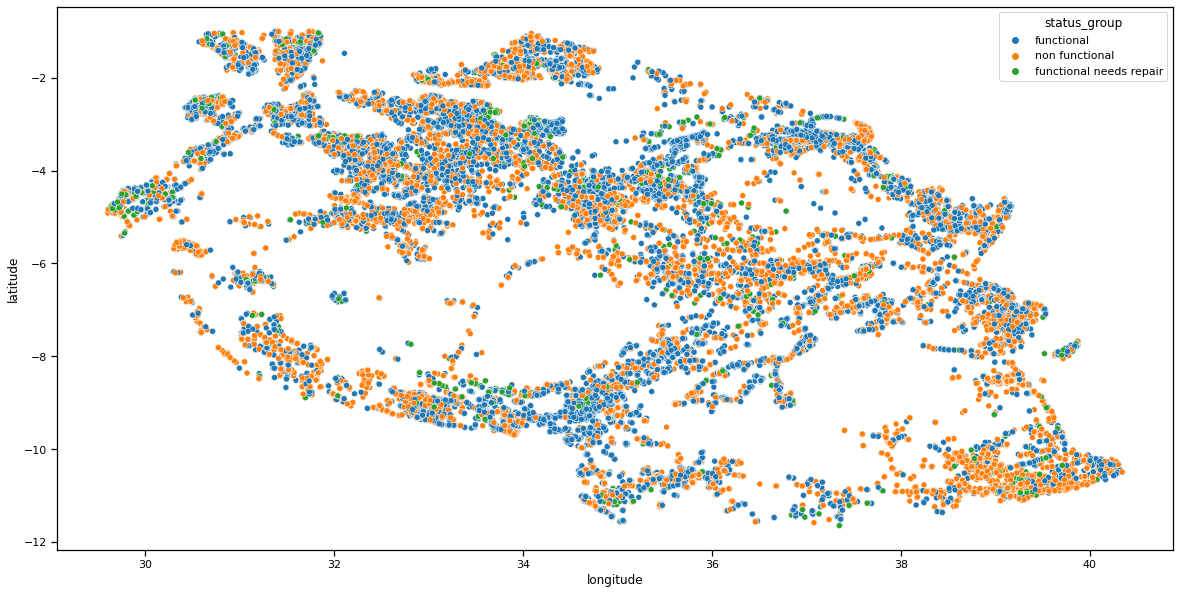

In [67]:
fig, ax  = plt.subplots(figsize=(20,10))
loc_data = train_data.loc[(train_data.longitude>0) & (train_data.latitude<0)]
sns.scatterplot(data=loc_data, x="longitude", y="latitude", hue="status_group", ax=ax);

        

**3. Visualizing the effect of the water point type on the functionality status of water pumps**


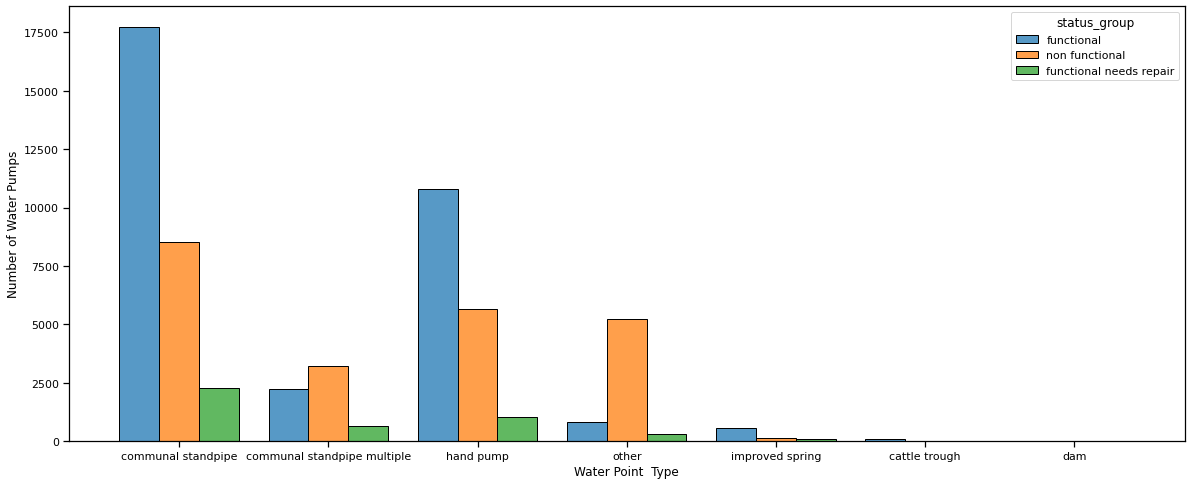

In [68]:
fig, ax  = plt.subplots(figsize=(20,8))
sns.histplot(data=train_data, x="waterpoint_type", hue="status_group", multiple="dodge", shrink=.8, ax=ax)
ax.set_xlabel('Water Point  Type')
ax.set_ylabel('Number of Water Pumps');



 #### **4. Visualizing the functionality status of water pumps by the construction year**

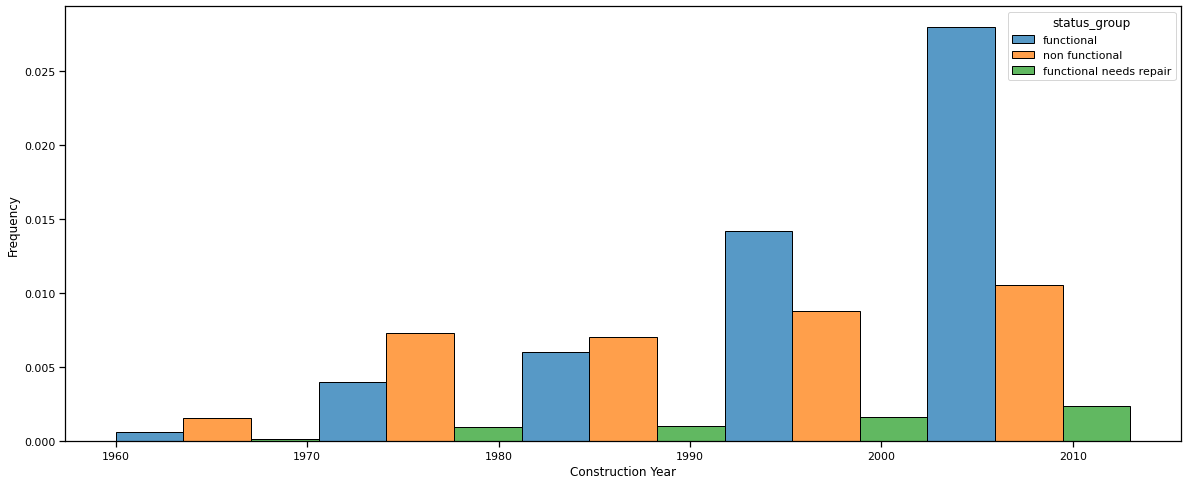

In [69]:
year = train_data[train_data['construction_year'] >0]
fig, ax  = plt.subplots(figsize=(20,8))
sns.histplot(data=year, x='construction_year', stat='density', hue='status_group', multiple='dodge',bins=5, ax=ax)
ax.set_xlabel('Construction Year')
ax.set_ylabel('Frequency');


#### **5. Visualizing water quantity in a well to the functionality of the water pumps**

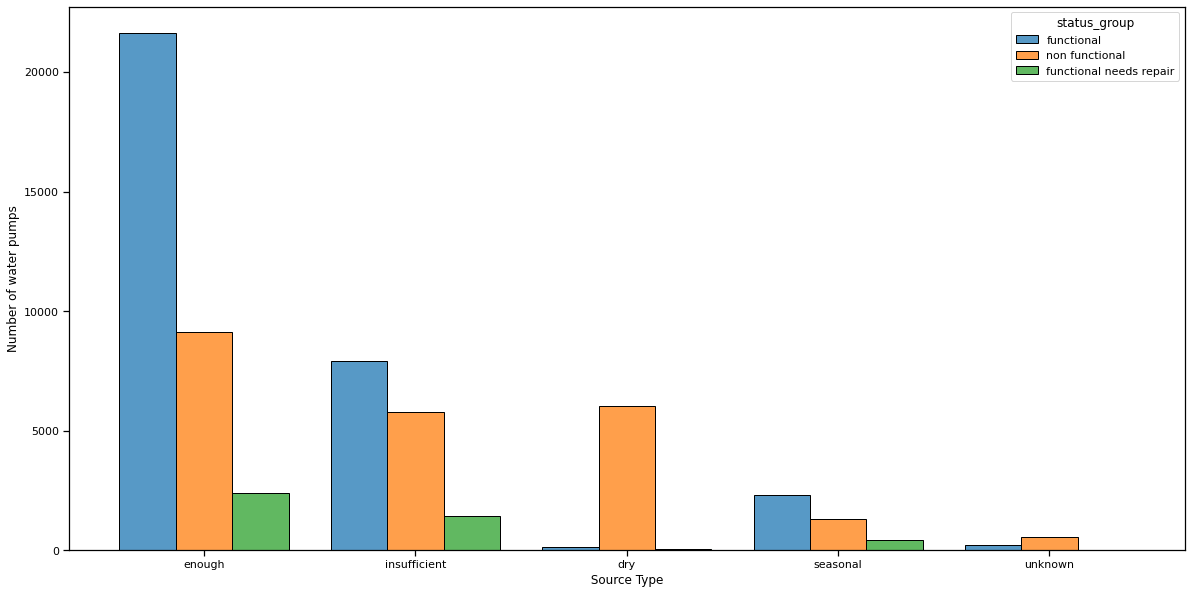

In [70]:
fig, ax  = plt.subplots(figsize=(20,10))
sns.histplot(data=train_data, x="quantity", hue="status_group", multiple="dodge", shrink=.8, ax=ax)
ax.set_xlabel(' Source Type ')
ax.set_ylabel('Number of water pumps');

#### **6. Visualizing the effect of water source type on the functionality of the water pumps**

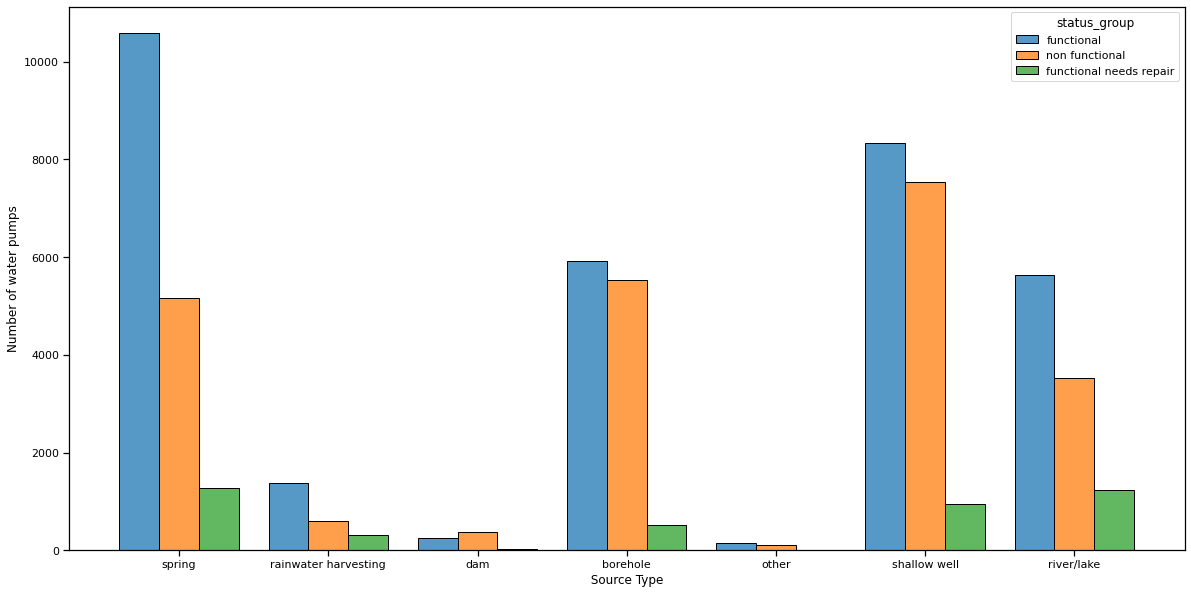

In [71]:
fig, ax  = plt.subplots(figsize=(20,10))
sns.histplot(data=train_data, x="source_type", hue="status_group", multiple="dodge", shrink=.8, ax=ax)
ax.set_xlabel(' Source Type ')
ax.set_ylabel('Number of water pumps');


#### **7. Visualizing the effect of water quality on the functionality status of the water pumps**

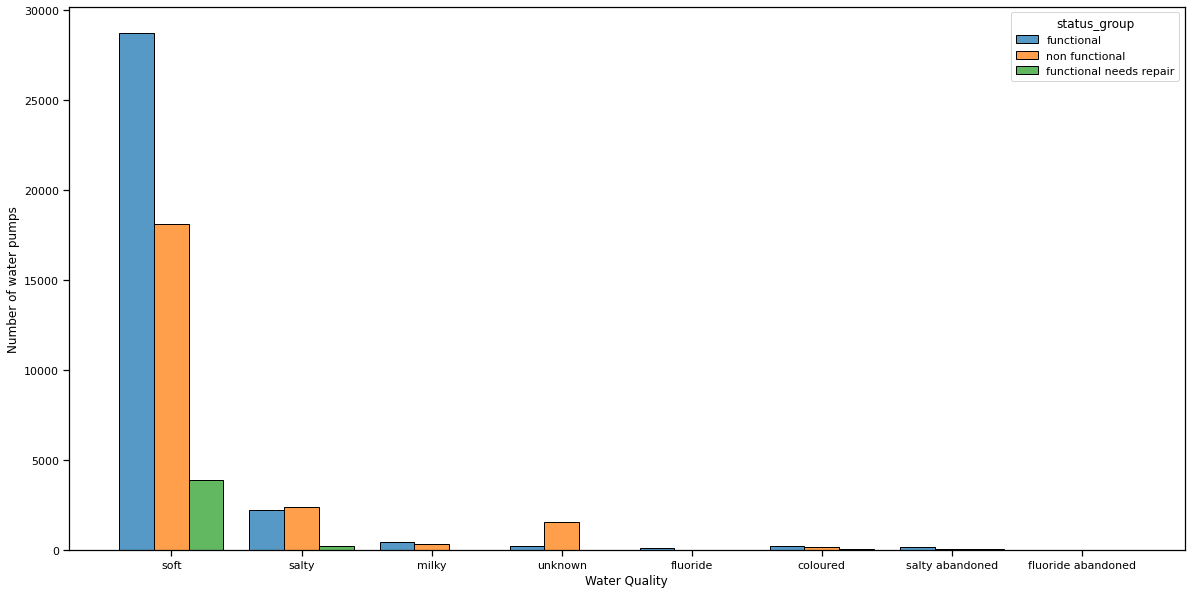

In [72]:
fig, ax  = plt.subplots(figsize=(20,10))
sns.histplot(data=train_data, x="water_quality", hue="status_group", multiple="dodge", shrink=.8, ax=ax)
ax.set_xlabel("Water Quality")
ax.set_ylabel("Number of water pumps");

 #### **8. Visualizing if the payment type influences the functionality status of the water pumps**

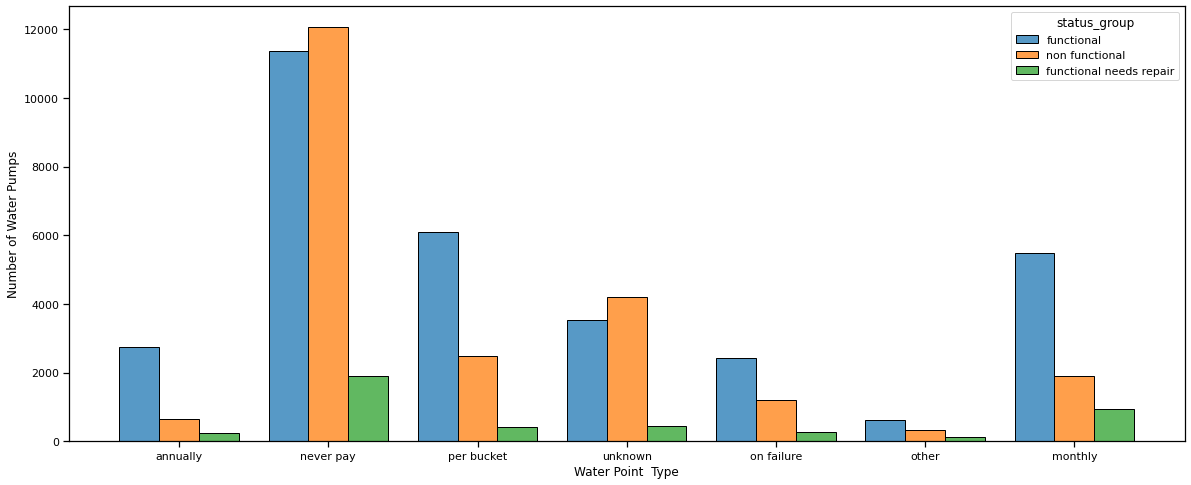

In [73]:
pop_status = train_data.groupby(['status_group'])['population'].sum()

fig, ax  = plt.subplots(figsize=(20,8))
sns.histplot(data=train_data, x="payment_type", hue="status_group", multiple="dodge", shrink=.8, ax=ax)
ax.set_xlabel('Water Point  Type')
ax.set_ylabel('Number of Water Pumps');

## DATA PREPARATION
 
 Handling high cardinality

In [74]:
print(train_data.groupby('payment_type')['status_group'].value_counts(normalize=True))


payment_type  status_group           
annually      functional                 0.752334
              non functional             0.179846
              functional needs repair    0.067820
monthly       functional                 0.660482
              non functional             0.227831
              functional needs repair    0.111687
never pay     non functional             0.475856
              functional                 0.448911
              functional needs repair    0.075233
on failure    functional                 0.620593
              non functional             0.308636
              functional needs repair    0.070772
other         functional                 0.579696
              non functional             0.308349
              functional needs repair    0.111954
per bucket    functional                 0.677796
              non functional             0.276683
              functional needs repair    0.045520
unknown       non functional             0.514527
            

In [75]:
train_data.isnull().sum()


id                          0
amount_tsh                  0
date_recorded               0
funder                   3635
gps_height                  0
installer                3655
longitude                   0
latitude                    0
basin                       0
region_code                 0
district_code               0
population                  0
permit                   3056
construction_year           0
extraction_type_class       0
management                  0
payment_type                0
water_quality               0
quantity                    0
source_type                 0
source_class                0
waterpoint_type             0
status_group                0
dtype: int64

In [76]:
# Function to identify missing columns
def is_missing(data):
    return data.columns[data.isin([0, -2.000000e-08]).any()]


In [77]:
# 1. Handling High Cardinality Columns

#top N frequent values, grouping the rest under "other".
    

def reduce_high_cardinality(data, column, top_n=4):
    
    top_values = data[column].value_counts().nlargest(top_n).index
    data[column] = data[column].apply(lambda x: x if x in top_values else 'other')
    return data

# Reduce high cardinality in 'funder' and 'installer'
train_data = reduce_high_cardinality(train_data, 'funder', top_n=4)
train_data = reduce_high_cardinality(train_data, 'installer', top_n=4)


print("Reduced 'funder' unique values:", train_data['funder'].nunique())
print(train_data['funder'].value_counts())

print("\nReduced 'installer' unique values:", train_data['installer'].nunique())
print(train_data['installer'].value_counts())



Reduced 'funder' unique values: 5
other                     43626
Government Of Tanzania     9084
Danida                     3114
Hesawa                     2202
Rwssp                      1374
Name: funder, dtype: int64

Reduced 'installer' unique values: 5
other         37907
DWE           17402
Government     1825
RWE            1206
Commu          1060
Name: installer, dtype: int64


In [78]:
# 2. Handling Missing Values

#Replace missing values in the column with random existing non-null values from the same column.

def impute_missing_random(data, column):
   
    non_null_values = data[column].dropna()
    data[column] = data[column].apply(lambda x: x if pd.notnull(x) else np.random.choice(non_null_values))
    return data

train_data = impute_missing_random(train_data, 'permit')

print("\nSample of 'permit' after imputation:")
print(train_data['permit'].value_counts(dropna=False))


Sample of 'permit' after imputation:
True     40942
False    18458
Name: permit, dtype: int64


In [79]:
# i. Replacing placeholders with NaN and imputing with the median
def replace_placeholders_with_median(data):
    # Define placeholder values to replace with NaN
    null_values = {
        'amount_tsh': 0,
        'gps_height': 0,
        'longitude': 0,
        'latitude': -2.000000e-08,
        'population': 0,
        'construction_year': 0
    }
    
    # Replace placeholders with NaN
    data = data.replace(null_values, np.nan)
    
    # Separate numeric and non-numeric data
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    non_numeric_cols = data.select_dtypes(exclude=['float64', 'int64']).columns
    
    # Impute only numeric columns
    imputer = SimpleImputer(strategy='median')
    data_numeric_imputed = pd.DataFrame(
        imputer.fit_transform(data[numeric_cols]),
        columns=numeric_cols,
        index=data.index
    )
    
    # Combine back with non-numeric columns
    data_combined = pd.concat([data_numeric_imputed, data[non_numeric_cols]], axis=1)
    return data_combined


train_data = replace_placeholders_with_median(train_data)


In [80]:
# ii. Replacing similar values with a common phrase
def replace_similar_values(data):
    data['management'] = data['management'].replace({
        'unknown': 'other',
        'other - school': 'school'
    })
    data['payment_type'] = data['payment_type'].replace({
        'unknown': 'other',
        'per bucket': 'pay(annual/per_bucket/on_failure/monthly)',
        'monthly': 'pay(annual/per_bucket/on_failure/monthly)',
        'on failure': 'pay(annual/per_bucket/on_failure/monthly)',
        'annually': 'pay(annual/per_bucket/on_failure/monthly)'
    })
    data['waterpoint_type'] = data['waterpoint_type'].replace(
        ['improved spring', 'cattle trough', 'dam'], 'other'
    )
    data['water_quality'] = data['water_quality'].replace({
        'salty abandoned': 'salty',
        'fluoride abandoned': 'fluoride'
    })
    return data

train_data = replace_similar_values(train_data)
train_data

,id,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year,date_recorded,...,permit,extraction_type_class,management,payment_type,water_quality,quantity,source_type,source_class,waterpoint_type,status_group
0,69572.0,6000.0,1390.0,34.938093,-9.856322,11.0,5.0,109.0,1999.0,2011-03-14,...,False,gravity,vwc,pay(annual/per_bucket/on_failure/monthly),soft,enough,spring,groundwater,communal standpipe,functional
1,8776.0,250.0,1399.0,34.698766,-2.147466,20.0,2.0,280.0,2010.0,2013-03-06,...,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310.0,25.0,686.0,37.460664,-3.821329,21.0,4.0,250.0,2009.0,2013-02-25,...,True,gravity,vwc,pay(annual/per_bucket/on_failure/monthly),soft,enough,dam,surface,communal standpipe multiple,functional
3,67743.0,250.0,263.0,38.486161,-11.155298,90.0,63.0,58.0,1986.0,2013-01-28,...,True,submersible,vwc,never pay,soft,dry,borehole,groundwater,communal standpipe multiple,non functional
4,19728.0,250.0,1167.0,31.130847,-1.825359,18.0,1.0,150.0,2000.0,2011-07-13,...,True,gravity,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739.0,10.0,1210.0,37.169807,-3.253847,3.0,5.0,125.0,1999.0,2013-05-03,...,True,gravity,water board,pay(annual/per_bucket/on_failure/monthly),soft,enough,spring,groundwater,communal standpipe,functional
59396,27263.0,4700.0,1212.0,35.249991,-9.070629,11.0,4.0,56.0,1996.0,2011-05-07,...,True,gravity,vwc,pay(annual/per_bucket/on_failure/monthly),soft,enough,river/lake,surface,communal standpipe,functional
59397,37057.0,250.0,1167.0,34.017087,-8.750434,12.0,7.0,150.0,2000.0,2011-04-11,...,False,handpump,vwc,pay(annual/per_bucket/on_failure/monthly),fluoride,enough,borehole,groundwater,hand pump,functional
59398,31282.0,250.0,1167.0,35.861315,-6.378573,1.0,4.0,150.0,2000.0,2011-03-08,...,True,handpump,vwc,never pay,soft,insufficient,shallow well,groundwater,hand pump,functional


In [81]:
# iii. Adding 'age' column
def add_age_column(data):
    year_recorded = pd.to_datetime(data['date_recorded']).dt.year
    data['year_recorded'] = year_recorded
    data['age'] = data['year_recorded'] - data['construction_year']
    return data

train_data = add_age_column(train_data)


In [82]:
# 1. Data Type Conversion. Convert boolean columns to binary floats using OrdinalEncoder.
def convert_boolean_to_binary(data, columns):
    
    encoder = OrdinalEncoder()
    data[columns] = encoder.fit_transform(data[columns].astype(str))
    return data

boolean_columns = ['permit']
train_data = convert_boolean_to_binary(train_data, boolean_columns)

In [83]:
# 3. Deal with Outliers by applying log transformation and clipping to handle extreme outliers.
def handle_outliers(data, columns):
    for column in columns:
        # Replace zero and negative values with the minimum positive value in the column
        min_positive_value = data[column][data[column] > 0].min()
        data[column] = data[column].apply(lambda x: min_positive_value if x <= 0 else x)

        # Log transformation
        data[column] = np.log1p(data[column])

        # Clipping to handle extreme values
        data[column] = np.clip(
            data[column], 
            a_min=data[column].quantile(0.01), 
            a_max=data[column].quantile(0.99)
        )
    return data


outlier_columns = ['amount_tsh', 'gps_height', 'population']


train_data = handle_outliers(train_data, outlier_columns)

print("Number of NaNs after handling outliers:")
print(train_data.isna().sum())


Number of NaNs after handling outliers:
id                       0
amount_tsh               0
gps_height               0
longitude                0
latitude                 0
region_code              0
district_code            0
population               0
construction_year        0
date_recorded            0
funder                   0
installer                0
basin                    0
permit                   0
extraction_type_class    0
management               0
payment_type             0
water_quality            0
quantity                 0
source_type              0
source_class             0
waterpoint_type          0
status_group             0
year_recorded            0
age                      0
dtype: int64


In [84]:
# 6.  Analyze interactions between categorical variables and the target.

def analyze_interactions(data, target_column, categorical_columns):

    for column in categorical_columns:
        print(f"\n{column} vs {target_column}:")
        print(data.groupby(column)[target_column].value_counts(normalize=True))


categorical_columns = ['funder', 'installer', 'management']
analyze_interactions(train_data, 'status_group', categorical_columns)


funder vs status_group:
funder                  status_group           
Danida                  functional                 0.550096
                        non functional             0.398844
                        functional needs repair    0.051060
Government Of Tanzania  non functional             0.513320
                        functional                 0.409511
                        functional needs repair    0.077169
Hesawa                  non functional             0.469573
                        functional                 0.425068
                        functional needs repair    0.105359
Rwssp                   functional                 0.585881
                        non functional             0.334789
                        functional needs repair    0.079330
other                   functional                 0.575001
                        non functional             0.353574
                        functional needs repair    0.071425
Name: status_group, dtype: 

In [85]:
# iv. Dropping irrelevant columns
def drop_irrelevant_columns(data, columns_to_drop):
    return data.drop(columns_to_drop, axis=1)

irrelevant_columns2 = ['id', 'date_recorded', 'construction_year', 'year_recorded']
train_data = drop_irrelevant_columns(train_data, irrelevant_columns2)

In [86]:
# v. One-hot encoding categorical features
def one_hot_encode_features(X_train, X_val, cat_cols, cont_cols):
    # ColumnTransformer for one-hot encoding
    one_hot_encoding = ColumnTransformer(
        transformers=[('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_cols)],
        remainder='passthrough'  # Keep other columns as is
    )

    # Create pipeline and transform datasets
    ohe_pipe = Pipeline(steps=[('one_hot_encoding', one_hot_encoding)])
    X_train_encoded = ohe_pipe.fit_transform(X_train)
    X_val_encoded = ohe_pipe.transform(X_val)

    # Extract encoded feature names for categorical columns
    encoder = one_hot_encoding.named_transformers_["ohe"]
    category_labels = encoder.get_feature_names(input_features=cat_cols)

    # DataFrames for encoded data
    X_train_encoded = pd.DataFrame(X_train_encoded, columns=np.append(category_labels, cont_cols))
    X_val_encoded = pd.DataFrame(X_val_encoded, columns=np.append(category_labels, cont_cols))

    return X_train_encoded, X_val_encoded


In [87]:
# Separate features (X) and target (y) from the training data
X = train_data.drop(['status_group'], axis=1)  # Features
y = train_data['status_group']                # Target

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Separating categorical and continuous columns
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
cont_cols = [col for col in X_train.columns if X_train[col].dtype in ['float64', 'int64']]

# Display column types for verification
print("Categorical Columns:", cat_cols)
print("Continuous Columns:", cont_cols)


Categorical Columns: ['funder', 'installer', 'basin', 'extraction_type_class', 'management', 'payment_type', 'water_quality', 'quantity', 'source_type', 'source_class', 'waterpoint_type']
Continuous Columns: ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'permit', 'age']


In [88]:
# One-hot encoding categorical features
X_train_encoded, X_val_encoded = one_hot_encode_features(X_train, X_val, cat_cols, cont_cols)

# Display encoded datasets
print("X_train_encoded sample:")
print(X_train_encoded.head())

print("\nX_val_encoded sample:")
print(X_val_encoded.head())


X_train_encoded sample:
   funder_Danida  funder_Government Of Tanzania  funder_Hesawa  funder_Rwssp  \
0            0.0                            0.0            0.0           0.0   
1            0.0                            0.0            0.0           0.0   
2            0.0                            0.0            0.0           0.0   
3            0.0                            0.0            0.0           0.0   
4            0.0                            0.0            0.0           0.0   

   funder_other  installer_Commu  installer_DWE  installer_Government  \
0           1.0              0.0            0.0                   0.0   
1           1.0              0.0            0.0                   0.0   
2           1.0              0.0            0.0                   0.0   
3           1.0              0.0            0.0                   0.0   
4           1.0              0.0            0.0                   0.0   

   installer_RWE  installer_other  ...  waterpoint_type_

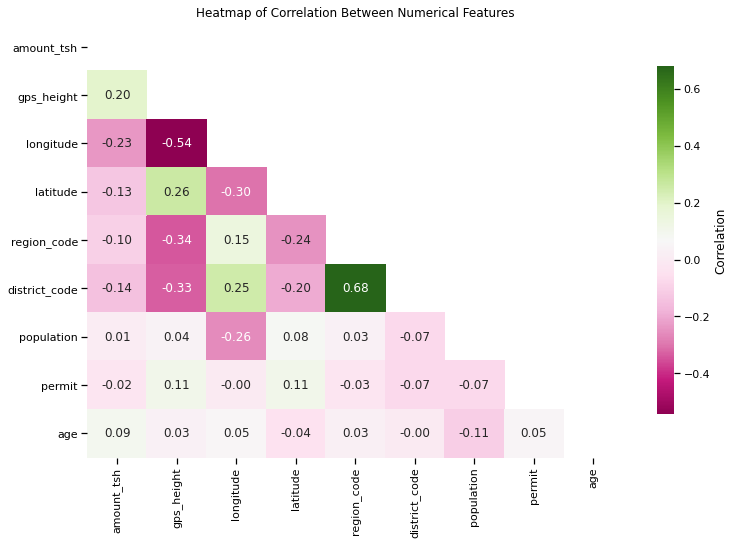

In [89]:
#heatmap of correlation for numerical features
def plot_numerical_correlation_heatmap(data):
   
    numerical_data = data.select_dtypes(include=['float64', 'int64'])
    
    # Calculate the correlation matrix
    corr_matrix = numerical_data.corr()
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="PiYG",
        mask=np.triu(np.ones_like(corr_matrix, dtype=bool)),
        cbar_kws={"shrink": 0.8, "label": "Correlation"}
    )
    ax.set_title("Heatmap of Correlation Between Numerical Features")
    plt.show()

plot_numerical_correlation_heatmap(X_train)

In [90]:
import sklearn
print(sklearn.__version__)


0.23.2


## Modelling

In [98]:
# DataFrame for model results
models = {
    'Model': [
        'Logistic Regression', 'Baseline Decision Tree', 
        'Random Forest', 'Gradient Boosting', 'Final Model (Optimized)'
    ],
    'Train Accuracy Score(%)': [0, 0, 0, 0, 0],
    'Test Accuracy Score(%)': [0, 0, 0, 0, 0]
}
df_model_results = pd.DataFrame(models, columns=['Model', 'Train Accuracy Score(%)', 'Test Accuracy Score(%)'])

In [99]:
# Function to update model results
def model_results(model_type, y_train, y_train_pred, y_test, y_test_pred):
    index_val = df_model_results[df_model_results['Model'] == model_type].index
    df_model_results.loc[index_val, 'Train Accuracy Score(%)'] = round(accuracy_score(y_train, y_train_pred) * 100, 2)
    df_model_results.loc[index_val, 'Test Accuracy Score(%)'] = round(accuracy_score(y_test, y_test_pred) * 100, 2)
    return df_model_results


In [100]:
# Check for NaN values in X_train_encoded
print("Missing values in X_train_encoded:")
print(X_train_encoded.isnull().sum())


Missing values in X_train_encoded:
funder_Danida                    0
funder_Government Of Tanzania    0
funder_Hesawa                    0
funder_Rwssp                     0
funder_other                     0
                                ..
region_code                      0
district_code                    0
population                       0
permit                           0
age                              0
Length: 74, dtype: int64


In [101]:
# Check for NaN or invalid values in y_train
print("Missing or invalid values in y_train:")
print(y_train.isnull().sum())

Missing or invalid values in y_train:
0


In [102]:
# Check for infinite values in X_train_encoded
print("Are there infinite values in X_train_encoded?")
print(np.isinf(X_train_encoded).sum())

Are there infinite values in X_train_encoded?
funder_Danida                    0
funder_Government Of Tanzania    0
funder_Hesawa                    0
funder_Rwssp                     0
funder_other                     0
                                ..
region_code                      0
district_code                    0
population                       0
permit                           0
age                              0
Length: 74, dtype: int64


In [103]:

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

print("Resampling completed successfully!")


Resampling completed successfully!


In [ ]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression  # Import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

# 1. Logistic Regression
print("\n=== Logistic Regression ===")
logistic_regression = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
logistic_regression.fit(X_train_resampled, y_train_resampled)

# Predictions
y_train_pred_lr = logistic_regression.predict(X_train_resampled)
#y_test_pred_lr = logistic_regression.predict(X_test_encoded)

# Metrics
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_test_pred_lr))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred_lr))

# Update Results (ensure `model_results` function is defined elsewhere)
df_model_results = model_results('Logistic Regression', y_train_resampled, y_train_pred_lr, y_test, y_test_pred_lr)



=== Logistic Regression ===


NameError: name 'X_test_encoded' is not defined

In [104]:
# 1. Logistic Regression
print("\n=== Logistic Regression ===")
logistic_regression = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
logistic_regression.fit(X_train_resampled, y_train_resampled)

y_train_pred_lr = logistic_regression.predict(X_train_resampled)
y_test_pred_lr = logistic_regression.predict(X_test_encoded)

print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_test_pred_lr))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred_lr))

df_model_results = model_results('Logistic Regression', y_train_resampled, y_train_pred_lr, y_test, y_test_pred_lr)


=== Logistic Regression ===


NameError: name 'LogisticRegression' is not defined

In [97]:
# 1. Logistic Regression
print("\n=== Logistic Regression ===")
logistic_regression = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
logistic_regression.fit(X_train_resampled, y_train_resampled)

y_train_pred_lr = logistic_regression.predict(X_train_resampled)
y_test_pred_lr = logistic_regression.predict(X_test_encoded)

# Metrics
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_test_pred_lr))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred_lr))

# Update Results
df_model_results = model_results('Logistic Regression', y_train_resampled, y_train_pred_lr, y_test, y_test_pred_lr)



=== Logistic Regression ===


NameError: name 'LogisticRegression' is not defined